# Guide
In this notebook we change the dataset to data1 becouse have the half of the data for the test provider but is also enouth if the distribution of lost data is distributed in the same way.

# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [1]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

# Imports

In [2]:
pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.9 MB/s 


In [3]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 2.3 MB/s 
     |████████████████████████████████| 16.7 MB 322 kB/s 
     |████████████████████████████████| 6.3 MB 40.8 MB/s 


In [4]:
#Pandas import
import pandas as pd
#Numpy import
import numpy as np
#Seaborn import
import seaborn as sns
#Geospatial imports
import matplotlib.pyplot as plt
import geopandas as gpd
#Import KMZ
import fiona
#Forecast time series
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
#Import for autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#Import for arima model
from statsmodels.tsa.arima_model import ARIMA
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Get data

In [69]:
query = """
SELECT * FROM `vacio-276411.mainDataset.V1_trips_grouped_all_hours`
"""
df_tripsa_grouped = client.query(query).to_dataframe()

In [70]:
df_tripsa_grouped

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,0
1,1,2021-05-04 01:00:00+00:00,4
2,1,2021-05-04 02:00:00+00:00,2
3,1,2021-05-04 03:00:00+00:00,30
4,1,2021-05-04 04:00:00+00:00,49
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


In [71]:
df_tripsa_grouped.reset_index(drop=True)

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,0
1,1,2021-05-04 01:00:00+00:00,4
2,1,2021-05-04 02:00:00+00:00,2
3,1,2021-05-04 03:00:00+00:00,30
4,1,2021-05-04 04:00:00+00:00,49
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


# Timeseries

Create lag

In [73]:
#Shift method to create the lag variables
df_tripsa_grouped['trips_lag_28_days'] = df_tripsa_grouped['trips'].shift(28*24) #28 days before same hour
df_tripsa_grouped['trips_lag_14_days'] = df_tripsa_grouped['trips'].shift(14*24) #14 days before same hour
df_tripsa_grouped['trips_lag_7_days'] = df_tripsa_grouped['trips'].shift(7*24) #7 days before same hour
df_tripsa_grouped['trips_lag_1_days'] = df_tripsa_grouped['trips'].shift(1*24) # 1 day before same hour
df_tripsa_grouped['trips_lag_2_days'] = df_tripsa_grouped['trips'].shift(2*24) # 2 days before same hour
df_tripsa_grouped['trips_lag_1_hours'] = df_tripsa_grouped['trips'].shift(1) # 1 hour before
df_tripsa_grouped['trips_lag_2_hours'] = df_tripsa_grouped['trips'].shift(1) # 2 hours before
df_tripsa_grouped

#Save a copy
df_tripsa_grouped_original = df_tripsa_grouped.copy()

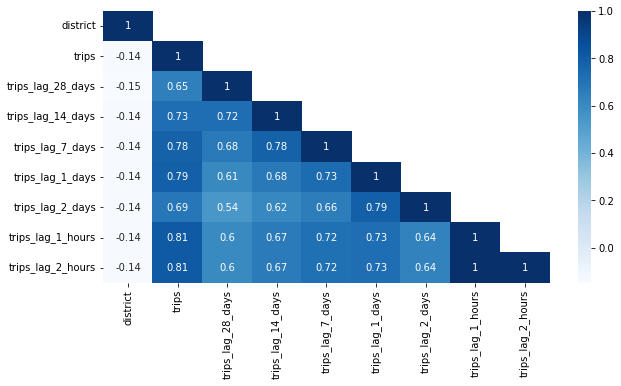

In [9]:
corr_matrix = df_tripsa_grouped.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="Blues")
plt.show()

Evaluation metric

In [10]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

Baseline

In [11]:
y_pred = df_tripsa_grouped['trips']
y_true = df_tripsa_grouped['trips_lag_1_hours']

In [12]:
result_1 = {'Method':['Baseline'],'MAPE':[mape(y_true, y_pred)],'WMAPE':[wmape(y_true, y_pred)]}
df_results = pd.DataFrame(result_1)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.620169,0.346036


Spit data\

In [15]:
#Split data
#TODO: Without change this date in the future the test list will be bigger than now
#split_point = 40
#TODO: Remove august becouse is not ready

df_tripsa_grouped =  df_tripsa_grouped[df_tripsa_grouped['dateandtime'] < '2022-06-01']

split_point = '2022-05-01'
filter_train = df_tripsa_grouped['dateandtime'] < split_point
filter_valid = df_tripsa_grouped['dateandtime'] >= split_point

df_all_hours_data_train = df_tripsa_grouped[ filter_train].copy()
df_all_hours_data_valid = df_tripsa_grouped[ filter_valid ].copy()

Train model

In [16]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[features])
ytr = df_all_hours_data_train['trips']

mdlRFR = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdlRFR.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

Evaluate model

In [17]:
Xval = imputer.transform(df_all_hours_data_valid[features])
yval = df_all_hours_data_valid['trips']

p = mdlRFR.predict(Xval)

In [18]:
p

array([33.12, 30.48, 39.71, ..., 10.27, 10.61,  3.77])

In [19]:
result_2 = {'Method':'RandomForest_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_2, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.620169,0.346036
1,RandomForest_1,0.376914,0.204367


Check district 4 and draw result

In [23]:
filter_district_df_all_hours_data_train = df_all_hours_data_train['district'] == 1
filter_district_df_all_hours_data_valid = df_all_hours_data_valid['district'] == 1
filter_district_df_tripsa_grouped = df_tripsa_grouped['district'] == 1

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdlRFR.predict(Xval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


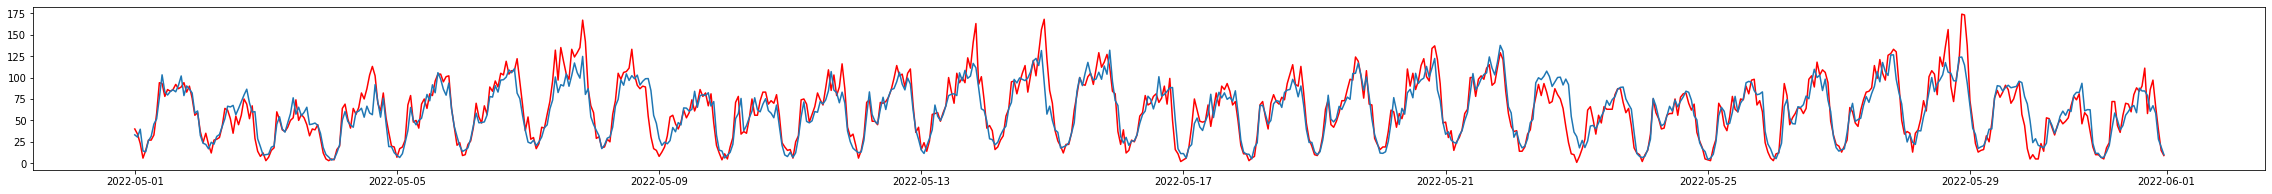

In [25]:
fig, ax = plt.subplots(figsize=(40, 3))

#Original
xpoints = df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['dateandtime']
yReal= df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['trips']

#Predicted
ypoints = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['dateandtime']
yEstimation = p

plt.plot(xpoints, yReal, c='red')
plt.plot(ypoints, yEstimation)
plt.show()

In [26]:
print('Mape for district 4' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 4 0.32412116746583697 WMAPE: 0.17990740700621763  Mean trips:  47.1671146953405  WMAPE percent: 0.003814255083616343


As we can see when the district has a low volume of data the prediction are worse than in the districts with more information.

This happend becouse the wmape is the same in all the districts but is not de same a MAPE of 1 in a data of 3 than in a data of 15

# Train a specific time series 
Train a specifict time series for this district to compare if the results could be better with a serie for every district instead of one for all

In [27]:
#Train model
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[filter_district_df_all_hours_data_train][features])
ytr = df_all_hours_data_train[filter_district_df_all_hours_data_train]['trips']

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)
#Evaluate model

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl.predict(Xval)
print('Mape for district 1' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 1 0.31187134478345824 WMAPE: 0.18561472302259582  Mean trips:  47.1671146953405  WMAPE percent: 0.003935257100662385


In [28]:
#Calculate error
result_3 = {'Method':'RandomForest_1_DISC_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.620169,0.346036
1,RandomForest_1,0.376914,0.204367
2,RandomForest_1_DISC_1,0.311871,0.185615


The result of the specific time series is as worst as with all the data

This doesn`t means that a global time series is as good as one for each district becouse maybe the data is not as good / as enought to have a better effect a individual time series

#Arima


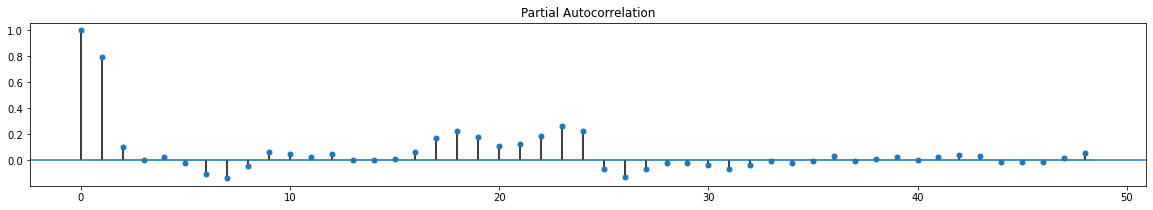

In [29]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_pacf(df_tripsa_grouped.trips, ax=ax, lags=2*24)
plt.show()

Estuding the Partial Autocorrelation select p as 1 or 24

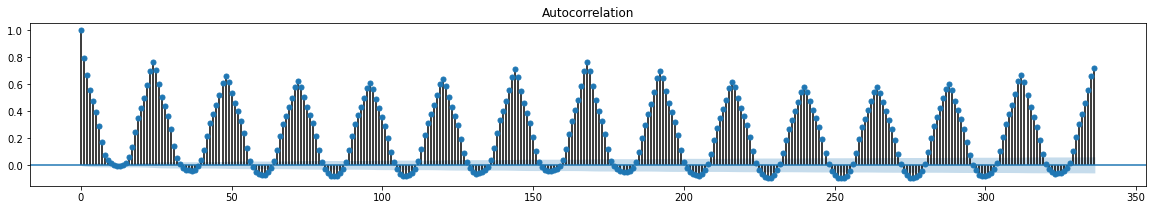

In [30]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_acf(df_tripsa_grouped.trips, ax=ax, lags=2*7*24)
plt.show()

Estuding the Autocorrelation select q as 24*7=168

In [31]:
#For arima model we only need one variable 'rides', the variable we want to predict
data_arima = df_tripsa_grouped['trips']
#Now only for district 1
train_arima= df_tripsa_grouped[filter_train][filter_district_df_all_hours_data_train]['trips']
valid_arima= df_tripsa_grouped[filter_valid][filter_district_df_all_hours_data_valid]['trips']

In [32]:
#Create the model with the train data
arima_model = ARIMA(train_arima, order=(24,0,6))
#Fit the model
model_fit = arima_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [33]:
#Print of the summary of results
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  trips   No. Observations:                 8688
Model:                    ARMA(24, 6)   Log Likelihood              -38466.586
Method:                       css-mle   S.D. of innovations             20.253
Date:                Wed, 31 Aug 2022   AIC                          76997.172
Time:                        15:28:57   BIC                          77223.402
Sample:                             0   HQIC                         77074.288
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           49.9212      1.713     29.142      0.000      46.564      53.279
ar.L1.trips      1.1234      0.185      6.057      0.000       0.760       1.487
ar.L2.trips     -0.9558      0.325     -2.94

In [34]:
#TODO: Analyze if are wihte noise

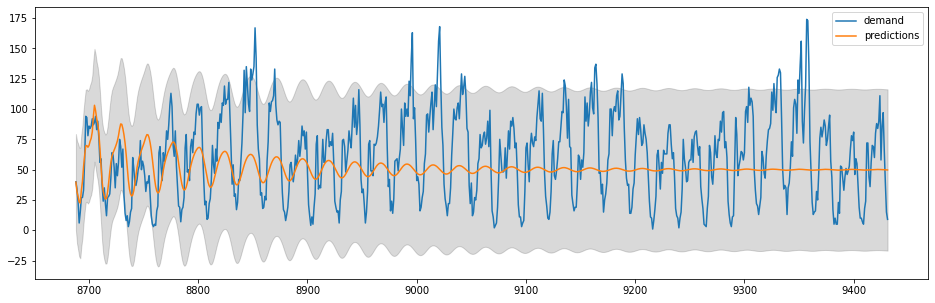

In [35]:
#obtain predictions and interval confidence of them
predictions, se, confidence = model_fit.forecast(len(valid_arima),alpha = 0.05) #95% confidence
predictions = pd.Series(predictions, index=valid_arima.index)
lower_band = pd.Series(confidence[:,0], index = valid_arima.index)
upper_band = pd.Series(confidence[:,1], index=valid_arima.index)

#Plot of predictions vs real demand and the interval of 95% confidence
plt.figure(figsize=(16,5))
plt.plot(valid_arima, label = 'demand')
plt.plot(predictions, label ='predictions')
plt.fill_between(lower_band.index, lower_band,upper_band, color='k', alpha=.15)
plt.legend()
plt.show()

In [36]:
#Calculate error
result_3 = {'Method':'Arima_4_0_1_ONLY_1','MAPE':mape(valid_arima,predictions),'WMAPE':wmape(valid_arima, predictions)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.620169,0.346036
1,RandomForest_1,0.376914,0.204367
2,RandomForest_1_DISC_1,0.311871,0.185615
3,Arima_4_0_1_ONLY_1,1.046165,0.452839


# Usar WAPE en lugar de RMSE
"Muchos clientes minoristas trabajan con datasets dispersos, donde la mayoría de sus SKUs se venden con poca frecuencia. Para la mayoría de los datos históricos, la demanda es 0. Para estos datasets, es importante tener en cuenta la escala de la demanda total, haciendo que wQL y WAPE sean una mejor métrica que RMSE para evaluar datasets dispersos. La métrica RMSE no toma en cuenta la escala de la demanda total y devuelve un valor RMSE más bajo considerando el número total de puntos de datos históricos y el número total de SKUs, dando una falsa sensación de seguridad de que se tiene un modelo preciso."

Fuente: https://aws.amazon.com/es/blogs/aws-spanish/midiendo-la-precision-de-modelos-de-forecast-para-optimizar-sus-objetivos-de-negocio-con-amazon-forecast/ apartado "Weighted absolute percentage error (WAPE)"

# Test
Test manual para comprobar calidad de los datos

In [63]:
df_tripsa_grouped

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,0
1,1,2021-05-04 01:00:00+00:00,4
2,1,2021-05-04 02:00:00+00:00,2
3,1,2021-05-04 03:00:00+00:00,30
4,1,2021-05-04 04:00:00+00:00,49
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


In [74]:
import datetime
df_test = df_tripsa_grouped_original[ (df_tripsa_grouped_original['dateandtime'].dt.date > datetime.datetime(2022, 6, 1).date() ) & (df_tripsa_grouped_original['dateandtime'].dt.date < datetime.datetime(2022, 6, 30).date() )  ]
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
9456,1,2022-06-02 00:00:00+00:00,6,7.0,10.0,3.0,4.0,7.0,11.0,11.0
9457,1,2022-06-02 01:00:00+00:00,13,17.0,9.0,11.0,4.0,5.0,6.0,6.0
9458,1,2022-06-02 02:00:00+00:00,13,19.0,15.0,12.0,15.0,18.0,13.0,13.0
9459,1,2022-06-02 03:00:00+00:00,21,27.0,32.0,53.0,28.0,24.0,13.0,13.0
9460,1,2022-06-02 04:00:00+00:00,80,68.0,63.0,93.0,77.0,72.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,28,25.0,24.0,44.0,37.0,26.0,31.0,31.0
103244,9,2022-06-29 20:00:00+00:00,49,24.0,22.0,36.0,45.0,33.0,28.0,28.0
103245,9,2022-06-29 21:00:00+00:00,18,16.0,13.0,15.0,13.0,7.0,49.0,49.0
103246,9,2022-06-29 22:00:00+00:00,6,15.0,4.0,4.0,4.0,4.0,18.0,18.0


In [75]:
Xval = imputer.transform(df_test[features])
yval = df_test['trips']

p = mdl.predict(Xval)

In [76]:
df_test = df_test.assign(prediction = p)
df_test[['trips','prediction']]

,trips,prediction
9456,6,7.85
9457,13,9.22
9458,13,13.64
9459,21,24.66
9460,80,32.09
...,...,...
103243,28,41.28
103244,49,33.17
103245,18,21.78
103246,6,26.56


In [77]:
df_test['desviacion'] = abs(df_test['trips'] - df_test['prediction'])
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours,prediction,desviacion
9456,1,2022-06-02 00:00:00+00:00,6,7.0,10.0,3.0,4.0,7.0,11.0,11.0,7.85,1.85
9457,1,2022-06-02 01:00:00+00:00,13,17.0,9.0,11.0,4.0,5.0,6.0,6.0,9.22,3.78
9458,1,2022-06-02 02:00:00+00:00,13,19.0,15.0,12.0,15.0,18.0,13.0,13.0,13.64,0.64
9459,1,2022-06-02 03:00:00+00:00,21,27.0,32.0,53.0,28.0,24.0,13.0,13.0,24.66,3.66
9460,1,2022-06-02 04:00:00+00:00,80,68.0,63.0,93.0,77.0,72.0,21.0,21.0,32.09,47.91
...,...,...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,28,25.0,24.0,44.0,37.0,26.0,31.0,31.0,41.28,13.28
103244,9,2022-06-29 20:00:00+00:00,49,24.0,22.0,36.0,45.0,33.0,28.0,28.0,33.17,15.83
103245,9,2022-06-29 21:00:00+00:00,18,16.0,13.0,15.0,13.0,7.0,49.0,49.0,21.78,3.78
103246,9,2022-06-29 22:00:00+00:00,6,15.0,4.0,4.0,4.0,4.0,18.0,18.0,26.56,20.56


In [78]:
df_test_error = df_test.groupby('trips')['desviacion'].mean().reset_index()
df_test_error

,trips,desviacion
0,0,41.239500
1,1,4.163167
2,2,3.800353
3,3,3.295765
4,4,3.552397
...,...,...
155,169,41.180000
156,172,43.700000
157,213,138.910000
158,226,153.070000


In [79]:
df_test_error['fallo'] = df_test_error['desviacion'] / df_test_error['trips']
df_test_error

,trips,desviacion,fallo
0,0,41.239500,inf
1,1,4.163167,4.163167
2,2,3.800353,1.900176
3,3,3.295765,1.098588
4,4,3.552397,0.888099
...,...,...,...
155,169,41.180000,0.243669
156,172,43.700000,0.254070
157,213,138.910000,0.652160
158,226,153.070000,0.677301


In [80]:
#Marco como aceptable un desajuste de viajes en un 15%
df_test_error['aceptable'] = df_test_error['fallo'] < 0.15
df_test_error

,trips,desviacion,fallo,aceptable
0,0,41.239500,inf,False
1,1,4.163167,4.163167,False
2,2,3.800353,1.900176,False
3,3,3.295765,1.098588,False
4,4,3.552397,0.888099,False
...,...,...,...,...
155,169,41.180000,0.243669,False
156,172,43.700000,0.254070,False
157,213,138.910000,0.652160,False
158,226,153.070000,0.677301,False


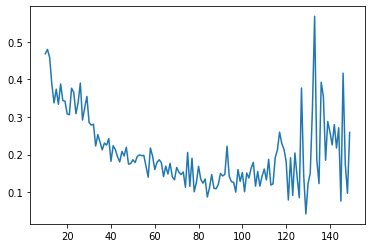

In [81]:
#import matplotlib.pyplot as plt
#import numpy as np

xpoints = np.array([1, 2, 6, 8])
ypoints = np.array([3, 8, 1, 10])

#Remove first and las 10 to not lose the data size of the plot
plt.plot(df_test_error['trips'][10:-10], df_test_error['fallo'][10:-10] )
plt.show()

As we can see the mayority of the data is in 20% of margin error

## Testing

In [83]:
query = """
SELECT timestamp_start AS date_time, latitud_start AS lat, longitud_start AS lon FROM `vacio-276411.mainDataset.trips_b` WHERE DATE(timestamp_start) = '2022-08-25' LIMIT 1000
"""
df_testing = client.query(query).to_dataframe()
df_testing['lat'] = df_testing['lat'].astype(str).astype(float)
df_testing['lon'] = df_testing['lon'].astype(str).astype(float)